![](https://www.python.org/static/img/python-logo.png)

# Python code against local PostgreSQL: Simple Gender Pay Gap analysis
---
<!-- <span style="color:lightblue"> -->
<font color=lightblue>
<i>
The overall goal of the project is to demonstrate simple UK Gender Pay Gap
analysis using the SIC Code information.<br><br>

The UK Gender Pay Gap data has been imported into my local PostgreSQL Server
as a mid-sized table (almost 40k rows) called `gender_pay_gap`. SIC Code
information has been added as several tables, the key being `siccodes`.
The SIC code column in `gender_pay_gap` has been normalized and captured
in a view, `vw_gpg_sic_codes`.

</i>
</font>
<!-- </span> -->

---
## Connectivity requirements

_To connect to my local postgreSQL server, we need the following:_

```python
db_name = <name of a database>
db_user = <a user with rights to the above database>
pwd = <the user's password>
db_host = 'localhost'
db_port = <the proper port number>
```


In [1]:
# To run the code in this notebook, these variables need valid values:
db_name = '********'
db_user = '********'
db_pwd = '********'
# These variables are defaults.
db_host = 'localhost'
db_port = 5432

---
## Imports

_We use `psychopg2` to connect to the PostgreSQL server. We use `pandas` to work with DataFrames and similar. `Seaborn` and `matplotlib` are for visualizations._

In [3]:
import psycopg2
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker

---
## Function declarations

_I'm wrapping two basic processes into python functions:_
> `create_connection()`: a function to establish a connection to a PostgreSQL Server database

> `create_sql_dataframe()`: a function to run a SELECT query against a database connection
        and return a pandas DataFrame


In [4]:
# *************************************************
# function definition ——create_connection()——
# *************************************************
def create_connection( 
                db_name=None, 
                db_user='gpg_guest',
                db_password='gpg_guest_123!@#',
                db_host='localhost',
                db_port=5432
                ):
    '''
    ——————————————————————————————————————————————
    Parameters:
    db_name : name of the database to which we are connecting

    db_user : name of a valid database user

    db_password : password assigned to <db_user>

    db_host : connection string for the PostgreSQL Server;
        for a locally installed server, "localhost" is most
        likely correct

    db_port : port used 
    
    ——————————————————————————————————————————————
    
    The function returns:
        >> a psychopg2 database connection object
        >> an Exception object
        >> a status message

    ——————————————————————————————————————————————
    '''
    db_connection = None
    return_err = None
    return_str = ''
    try:
        db_connection = psycopg2.connect(
            database=db_name,
            user=db_user,
            password=db_password,
            host=db_host,
            port=db_port,
        )
        return_err = None
        return_str = "Connection to PostgreSQL DB successful"

    # except OperationalError as e:
    except Exception as e:
        return_err = e
        return_str = f"Connection failed with error '{e}'."

    return db_connection, return_err, return_str
# *************************************************
# end function ——create_connection()——
# *************************************************

In [5]:
# *************************************************
# function definition ——create_sql_dataframe()——
# *************************************************
def create_sql_dataframe( db_connection=None, querystring=None ):
    '''
    ——————————————————————————————————————————————
    Parameters:
    db_connection : a psychopg2 database connection object obtained from
             create_connection() or similar.

    querystring : valid PostgreSQL SQL.
    
    ——————————————————————————————————————————————
    
    The function returns:
        >> a pandas DataFrame object based on querystring
        >> an Exception object
        >> a status message

    ——————————————————————————————————————————————
    '''

    code_line = ''
    cur_open = False
    df = None
    return_err = None
    return_str = ''

    try:
        code_line = 'db_connection.cursor()'
        db_cursor = db_connection.cursor()

        code_line = 'db_cursor.execute(querystring)'
        cur_open = True
        db_cursor.execute(querystring)

        # The above execute() returns a list of tuples
        code_line = 'db_cursor.fetchall()'
        tuples_list = db_cursor.fetchall()

        # We need to build a list of column names in order to create
        # the pandas DataFrame object.
        code_line = 'db_cursor.description'
        curdesc_list = db_cursor.description

        code_line = 'list comprehension for cols_list[]'
        cols_list = [s.name for s in curdesc_list]

        # I think my logic is correct here: if the call to db_cursor.close()
        # fails, we don't need to try it again in the finally: block. So
        # setting the flag to False avoids a second attempt at closing in
        # the finally: block below.
        cur_open = False

        code_line = 'db_cursor.close()'
        db_cursor.close()

        code_line = 'df = pd.DataFrame()'
        # Now we need to transform the list into a pandas DataFrame:
        df = pd.DataFrame(tuples_list, columns=cols_list)

        return_str = "create_sql_dataframe() executed successfully"

    except Exception as e:
        return_err = e
        return_str = f"An error occurred: '{e}'.\nCode line:\n{code_line}"

    finally:
        if cur_open == True:
            db_cursor.close()

    return df, return_err, return_str
# *************************************************
# end function ——create_sql_dataframe()——
# *************************************************

---
## Retrieve the Gender Pay Gap data

_There are almost 40,000 records in my Gender Pay Gap database, as of February 4. When you break out the records for the SIC Codes, the number exceeds 50,000 records._

In [6]:
# This query should return all records from the gender_pay_gap table.
querystring = '''

SELECT 
	g.gpgkey
	, g.employerid
	, DATE_PART( 'year', g.duedate )::integer AS "gpg_year"
	, g.employername
	, g.employersize
	, e.employersizesequence
	, g.diffmeanhourlypercent
	, g.diffmedianhourlypercent
	, g.diffmeanbonuspercent
	, g.diffmedianbonuspercent
	, g.malebonuspercent
	, g.femalebonuspercent
	, g.malelowerquartile
	, g.femalelowerquartile
	, g.malelowermiddlequartile
	, g.femalelowermiddlequartile
	, g.maleuppermiddlequartile
	, g.femaleuppermiddlequartile
	, g.maletopquartile
	, g.femaletopquartile
	, g.submittedafterthedeadline
	, g.duedate
	, g.datesubmitted
	
FROM 
	gender_pay_gap g
	INNER JOIN employersizes e ON g.employersize = e.employersize
ORDER BY
	employerid
	, DATE_PART( 'year', g.duedate )::integer

'''

In [7]:
dbcon, dberr, dbmsg = create_connection( db_name, db_user, db_pwd )
print( dbmsg )

Connection to PostgreSQL DB successful


In [8]:
if dberr == None:
    df, dberr, dbmsg = create_sql_dataframe( dbcon, querystring )
    print( dbmsg )
    if dberr == None:
        dbcon.close()

create_sql_dataframe() executed successfully


In [9]:
df[0:4].T

,0,1,2,3
gpgkey,1053,11330,21399,28730
employerid,10,10,10,10
gpg_year,2018,2019,2020,2021
employername,BLACKWELL UK LIMITED,BLACKWELL UK LIMITED,BLACKWELL UK LIMITED,BLACKWELL UK LIMITED
employersize,250 to 499,250 to 499,250 to 499,250 to 499
employersizesequence,2,2,2,2
diffmeanhourlypercent,11.50,12.80,13.10,19.3
diffmedianhourlypercent,1.80,1.40,1.90,27.0
diffmeanbonuspercent,0.70,41.30,19.00,23.9
diffmedianbonuspercent,25.60,0.00,18.40,0.0


---
## Inspecting the DataFrame

In [10]:
df.dtypes

gpgkey                                int64
employerid                           object
gpg_year                              int64
employername                         object
employersize                         object
employersizesequence                  int64
diffmeanhourlypercent                object
diffmedianhourlypercent              object
diffmeanbonuspercent                 object
diffmedianbonuspercent               object
malebonuspercent                     object
femalebonuspercent                   object
malelowerquartile                    object
femalelowerquartile                  object
malelowermiddlequartile              object
femalelowermiddlequartile            object
maleuppermiddlequartile              object
femaleuppermiddlequartile            object
maletopquartile                      object
femaletopquartile                    object
submittedafterthedeadline              bool
duedate                      datetime64[ns]
datesubmitted                dat

In [11]:
# df.info( show_counts=False )
df.info( show_counts=True )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50227 entries, 0 to 50226
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   gpgkey                     50227 non-null  int64         
 1   employerid                 50227 non-null  object        
 2   gpg_year                   50227 non-null  int64         
 3   employername               50227 non-null  object        
 4   employersize               50227 non-null  object        
 5   employersizesequence       50227 non-null  int64         
 6   diffmeanhourlypercent      50227 non-null  object        
 7   diffmedianhourlypercent    50227 non-null  object        
 8   diffmeanbonuspercent       40777 non-null  object        
 9   diffmedianbonuspercent     40775 non-null  object        
 10  malebonuspercent           50227 non-null  object        
 11  femalebonuspercent         50227 non-null  object        
 12  male

In [12]:
# The above shows that several numeric fields were rendered as objects.
# I now force those columns to floats.
df['diffmeanhourlypercent'] = df['diffmeanhourlypercent'].astype( 'float' )
df['diffmedianhourlypercent'] = df['diffmedianhourlypercent'].astype( 'float' )
df['diffmeanbonuspercent'] = df['diffmeanbonuspercent'].astype( 'float' )
df['diffmedianbonuspercent'] = df['diffmedianbonuspercent'].astype( 'float' )
df['malebonuspercent'] = df['malebonuspercent'].astype( 'float' )
df['femalebonuspercent'] = df['femalebonuspercent'].astype( 'float' )
df['malelowerquartile'] = df['malelowerquartile'].astype( 'float' )
df['femalelowerquartile'] = df['femalelowerquartile'].astype( 'float' )
df['malelowermiddlequartile'] = df['malelowermiddlequartile'].astype( 'float' )
df['femalelowermiddlequartile'] = df['femalelowermiddlequartile'].astype( 'float' )
df['maleuppermiddlequartile'] = df['maleuppermiddlequartile'].astype( 'float' )
df['femaleuppermiddlequartile'] = df['femaleuppermiddlequartile'].astype( 'float' )
df['maletopquartile'] = df['maletopquartile'].astype( 'float' )
df['femaletopquartile'] = df['femaletopquartile'].astype( 'float' )
df.dtypes

gpgkey                                int64
employerid                           object
gpg_year                              int64
employername                         object
employersize                         object
employersizesequence                  int64
diffmeanhourlypercent               float64
diffmedianhourlypercent             float64
diffmeanbonuspercent                float64
diffmedianbonuspercent              float64
malebonuspercent                    float64
femalebonuspercent                  float64
malelowerquartile                   float64
femalelowerquartile                 float64
malelowermiddlequartile             float64
femalelowermiddlequartile           float64
maleuppermiddlequartile             float64
femaleuppermiddlequartile           float64
maletopquartile                     float64
femaletopquartile                   float64
submittedafterthedeadline              bool
duedate                      datetime64[ns]
datesubmitted                dat

In [13]:
# These are the principal measurements of the UK gender pay gap dataset. 
# I'm going to use this list for some evaluations below:
measures_list = [
    'diffmeanhourlypercent'
	, 'diffmedianhourlypercent'
	, 'diffmeanbonuspercent'
	, 'diffmedianbonuspercent'
	, 'malebonuspercent'
	, 'femalebonuspercent'
	, 'malelowerquartile'
	, 'femalelowerquartile'
	, 'malelowermiddlequartile'
	, 'femalelowermiddlequartile'
	, 'maleuppermiddlequartile'
	, 'femaleuppermiddlequartile'
	, 'maletopquartile'
	, 'femaletopquartile'
    ]

In [14]:
dfsubset = df[measures_list].describe().T
dfsubset["count"] = dfsubset["count"].astype(int)
dfsubset

,count,mean,std,min,25%,50%,75%,max
diffmeanhourlypercent,50227,13.978025,14.968091,-499.9,4.8,13.1,22.4,159.0
diffmedianhourlypercent,50227,12.209121,16.321452,-499.5,1.0,9.8,21.6,121.2
diffmeanbonuspercent,40777,17.127608,469.371756,-82000.0,0.5,31.4,55.6,3848.2
diffmedianbonuspercent,40775,-3.489412,746.725521,-120695.0,0.0,15.4,42.5,4000.0
malebonuspercent,50227,36.121507,37.220598,0.0,0.1,19.0,76.3,100.0
femalebonuspercent,50227,34.834498,36.946507,0.0,0.0,17.0,74.0,100.4
malelowerquartile,49830,45.648032,24.165755,0.0,26.3,43.9,64.0,100.0
femalelowerquartile,49830,54.351968,24.165755,0.0,36.0,56.1,73.7,100.0
malelowermiddlequartile,49830,49.988034,26.045271,0.0,29.0,48.0,71.9,100.0
femalelowermiddlequartile,49830,50.011966,26.045271,0.0,28.1,52.0,71.0,100.0


In [15]:
del dfsubset

_<font color="red">To see which values for specific columns in the dataframe are most common, I have several options.</font>_

_<font color="red">I can use `DataFrame.head()` with or without an argument.</font>_

```python
# Use .head()
df['diffmeanhourlypercent'].value_counts().head(10)
```

_<font color="red">For this dataset, `DataFrame.value_counts()` returns too many rows, but I can set that to a Series object and limit the output.</font>_

```python
# Use .head()
df['diffmeanhourlypercent'].value_counts().head(10)

n = 200

# Use a lambda function against a Series object
ser = df['diffmeanhourlypercent'].value_counts()
print( ser.loc[lambda x : (x >= n )] )

# Use .where against a Series object
ser = df['diffmeanhourlypercent'].value_counts()
ser.where( ser >= n ).dropna().astype(int)
```

In [16]:
ser = df['diffmeanhourlypercent'].value_counts()
n = 200
ser.where( ser >= n ).dropna().astype(int)

0.0     449
16.0    296
11.0    290
12.0    290
15.0    284
7.0     281
18.0    280
20.0    276
10.0    272
17.0    271
4.0     265
2.0     264
22.0    263
5.0     262
13.0    260
3.0     255
21.0    254
9.0     252
19.0    250
26.0    250
14.0    246
23.0    246
1.0     246
25.0    245
8.0     239
6.0     238
24.0    223
28.0    217
27.0    204
Name: diffmeanhourlypercent, dtype: int32

In [17]:
del ser

In [18]:
# The next set of commands uses value_counts() to get the frequency distribution, copies that
# to another DataFrame object (renaming the columns for clarity), then filters the results
# for the values below -100 and sorts.
col_renames = {'index':'diffmeanhourlypercent', 'diffmeanhourlypercent' : 'counts' }
dfsubset = df['diffmeanhourlypercent'].value_counts().reset_index().rename( columns=col_renames )
dfsubset.loc[ dfsubset.diffmeanhourlypercent < -0 ].sort_values( 'diffmeanhourlypercent' )

,diffmeanhourlypercent,counts
1473,-499.90,1
972,-400.00,1
1191,-379.60,1
963,-271.30,1
1179,-184.20,1
...,...,...
272,-0.10,77
1077,-0.09,1
1026,-0.05,1
1441,-0.04,1


In [19]:
# Filter the data for cases where the pay gap favors women

dfsubset = df[ df['diffmeanhourlypercent'] < 0 ]
dfsubset = df[ [ 'gpg_year', 'diffmeanhourlypercent' ] ]
dfsubset = df[ [ 'gpg_year', 'diffmeanhourlypercent' ] ][ df['diffmeanhourlypercent'] < 0 ]

x = dfsubset
# dfxtab = pd.crosstab( x.diffmeanhourlypercent, x.gpg_year, values=x.count_adjusted, margins = True, margins_name = 'Total', aggfunc = 'sum' )
dfxtab = pd.crosstab( x.diffmeanhourlypercent, x.gpg_year, margins = True, margins_name = 'Total' )
dfxtab.fillna(0)

gpg_year,2018,2019,2020,2021,2022,2023,Total
diffmeanhourlypercent,,,,,,,
-499.9,0,0,1,0,0,0,1
-400.0,1,0,0,0,0,0,1
-379.6,0,0,0,0,1,0,1
-271.3,0,0,0,1,0,0,1
-184.2,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...
-0.09,0,0,0,0,0,1,1
-0.05,0,0,0,0,0,1,1
-0.04,0,0,0,0,0,1,1


---
## Visualizing the data

_<font color="red">In the charts which follow, I'm using style "classic."</font>_

_<font color="red">To see other available styles:</font>_

```python
plt.style.available
```


In [20]:
plt.style.use( 'classic' )

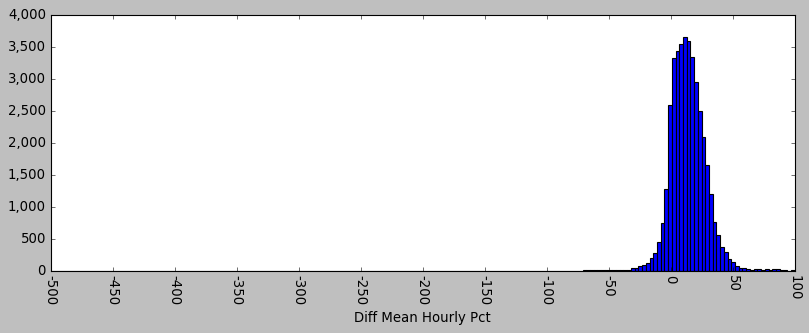

In [21]:
# Using matplotlib's histogram

# I have questions about 2018 data.
dfplotted = df['diffmeanhourlypercent'][ df['gpg_year'] != 2018 ]

min = dfplotted.min() / 100
max = dfplotted.max() / 100
if ( min % 1 != 0 ): min = min - 1
if ( max % 1 != 0 ): max = max + 1
min = int( min ) * 100
max = int( max ) * 100

# The variable ax is a matplotlib AxesSubplot object.
# The variable fig is a matplotlib Figure object.
fig, ax = plt.subplots( figsize=(12, 4) )

# The call to matplotlib's hist() method returns a tuple. This is in contrast to
# the seaborn library, where the call to histogram method ("histplot()") returns
# the matplotlib AxesSubplot object we got from plt.subplots().
plt.hist( dfplotted , bins=200 )

# Format the x-axis:
xticks = [x for x in range( min, max+1, 50 )]
plt.xticks( ticks=xticks, labels=xticks, rotation=-90)
ax.set_xlabel( xlabel = 'Diff Mean Hourly Pct' )

# Format the y-axis:
yticks = plt.gca().get_yticks()
ylabels = ['{:,.0f}'.format(y) for y in yticks ]
plt.yticks( ticks=yticks, labels=ylabels )

plt.show() ;

_<font color="red">This next graph shows the distribution where the pay gap favors women. There are far fewer cases.</font>_

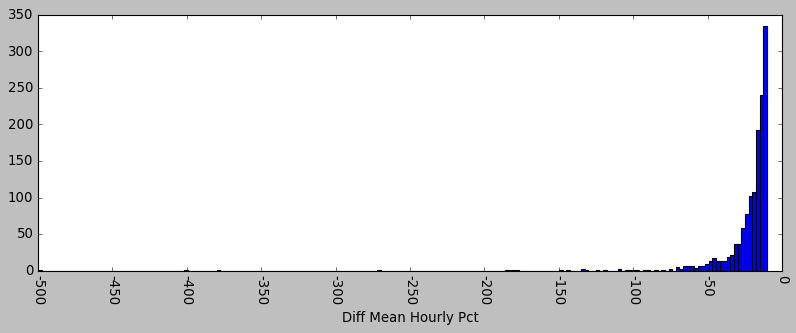

In [22]:
# Using matplotlib's histogram

dfplotted = df['diffmeanhourlypercent'][ df['diffmeanhourlypercent'] < -10 ]

min = dfplotted.min() / 100
max = dfplotted.max() / 100
if ( min % 1 != 0 ): min = min - 1
if ( max % 1 != 0 ): max = max + 1
min = int( min ) * 100
max = int( max ) * 100

# The variable ax is a matplotlib AxesSubplot object.
# The variable fig is a matplotlib Figure object.
fig, ax = plt.subplots( figsize=(12, 4) )

# The call to matplotlib's hist() method returns a tuple. This is in contrast to
# the seaborn library, where the call to histogram method ("histplot()") returns
# the matplotlib AxesSubplot object we got from plt.subplots().
plt.hist( dfplotted , bins=200 )

# Format the x-axis:
xticks = [x for x in range( min, max+1, 50 )]
plt.xticks( ticks=xticks, labels=xticks, rotation=-90)
ax.set_xlabel( xlabel = 'Diff Mean Hourly Pct' )

# Format the y-axis:
yticks = plt.gca().get_yticks()
ylabels = ['{:,.0f}'.format(y) for y in yticks ]
plt.yticks( ticks=yticks, labels=ylabels )

plt.show() ;

_<font color="red">As we can see from above very, there are few cases where the pay gap favors women.</font>_

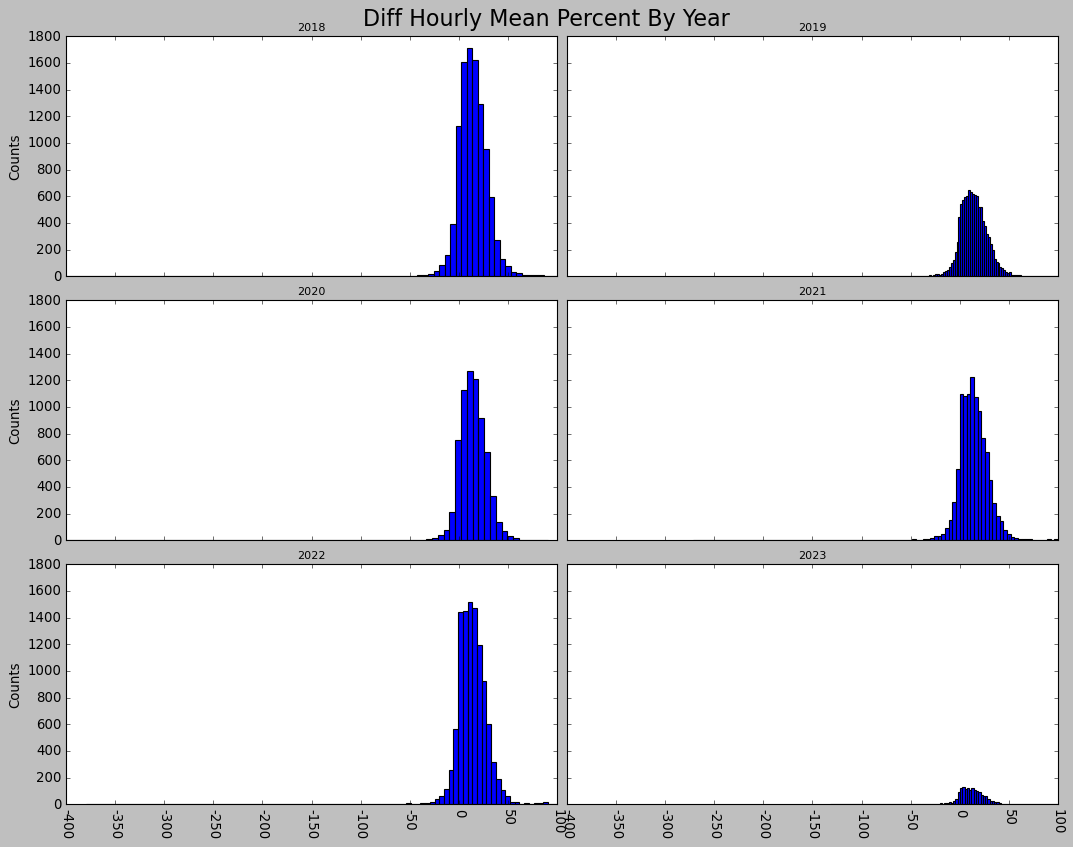

In [23]:
# Using matplotlib's histogram

nbins = 100

# The variable ax is a matplotlib AxesSubplot object.
# The variable fig is a matplotlib Figure object.
fig, ax = plt.subplots( nrows = 3,
                    ncols = 2, 
                    figsize = (16, 12), 
                    sharey = True,
                    sharex = True
                      )

plt.subplots_adjust( left=0.125, 
                    bottom=0.15, 
                    right=0.9, 
                    top=0.95, 
                    wspace=0.02, 
                    hspace=0.1
                   )

# fig.tight_layout( pad=4.0 )
fig.suptitle( 'Diff Hourly Mean Percent By Year', fontsize = 20 )

ax[0, 0].set_ylabel( 'Counts' )
ax[1, 0].set_ylabel( 'Counts' )
ax[2, 0].set_ylabel( 'Counts' )

# xtick_list = [-500, -450, -400, -350, -300, -250, -200, -150, -100, -50, 0, 50, 100]
xtick_list = [ -400, -350, -300, -250, -200, -150, -100, -50, 0, 50, 100]

for iyear in range( 2018, 2024 ):
    i = iyear - 2018
    x = int( i / 2)
    y = i % 2
    r = ax[ x, y ]

    dfplotted = df['diffmeanhourlypercent'][ df['gpg_year'] == iyear ]

    r.hist( dfplotted, bins=nbins )
    r.set_title( iyear, fontsize = 10 )

    r.xaxis.set_major_locator( mticker.FixedLocator( xtick_list ))
    r.set_xticklabels( labels=xtick_list, rotation=-90) 
    # r.set_xlabel( xlabel = 'Diff Mean Hourly Pct' )

plt.xlim(-400, 100)

del i, x, y, r

plt.show() ;

---
## Adding SIC Data

_Now that I've explored the DataFrame using a fairly simple query, I'll add in the SIC Code data._

_One thing I'll keep in mind is the distortion of counts. Each row in the dataset no longer represents one filing per year. Since we've split up (normalized) the SIC code data, one filing can be represented by as many as rows as SIC codes that the company provided.__

In [24]:
# This query returns the gender_pay_gap table with SIC code info also.

querystring = '''

SELECT 
	g.gpgkey
	, g.employerid
	, COALESCE( v.counter, 1 ) AS "counter"
    , ( 1.0 / COALESCE( v.counter, 1 )::float ) AS "counter_adj"
	, COALESCE( v.siccode_count, 0 ) AS "siccode_count"
	, CASE COALESCE( v.siccode_count, 0 )::float
            WHEN 0 THEN 0
            ELSE ( 1 / COALESCE( v.siccode_count, 0 )::float )
            END
            AS "siccode_count_adj"
	, DATE_PART( 'year', g.duedate )::integer AS "gpg_year"
	, g.employername
	, g.employersize
	, e.employersizesequence
	, v.siccode
	, s.sectiondescription
	, s.sicsection
	, s.divisiondescription
	, v.sicdivision
	, s.groupdescription
	, v.sicgroup
	, g.diffmeanhourlypercent
	, g.diffmedianhourlypercent
	, g.diffmeanbonuspercent
	, g.diffmedianbonuspercent
	, g.malebonuspercent
	, g.femalebonuspercent
	, g.malelowerquartile
	, g.femalelowerquartile
	, g.malelowermiddlequartile
	, g.femalelowermiddlequartile
	, g.maleuppermiddlequartile
	, g.femaleuppermiddlequartile
	, g.maletopquartile
	, g.femaletopquartile
	, g.submittedafterthedeadline
	, g.duedate
	, g.datesubmitted
	
FROM 
	gender_pay_gap g
	LEFT JOIN vw_gpg_sic_codes v ON g.gpgkey = v.gpgkey
	LEFT JOIN vw_siccode_plus s ON v.siccode = s.siccode
	INNER JOIN employersizes e ON g.employersize = e.employersize
ORDER BY
	employerid
	, DATE_PART( 'year', g.duedate )::integer
	, v.counter

'''

In [25]:
dbcon, dberr, dbmsg = create_connection( db_name, db_user, db_pwd )
print( dbmsg )

Connection to PostgreSQL DB successful


In [26]:
if dberr == None:
    df, dberr, dbmsg = create_sql_dataframe( dbcon, querystring )
    print( dbmsg )
    if dberr == None:
        dbcon.close()

create_sql_dataframe() executed successfully


In [27]:
print( f"'sectiondescription' has {df[ 'sectiondescription' ].nunique()} unique values." )
print( f"'divisiondescription' has {df[ 'divisiondescription' ].nunique()} unique values." )
print( f"'diffmeanhourlypercent' has {df[ 'diffmeanhourlypercent' ].nunique()} unique values." )

'sectiondescription' has 21 unique values.
'divisiondescription' has 86 unique values.
'diffmeanhourlypercent' has 1571 unique values.


In [28]:
print( df[ 'sectiondescription' ].nunique())
df['sectiondescription'].unique()

21


array(['Wholesale and retail trade; repair of motor vehicles and motorcycles',
       None, 'Administrative and support service activities',
       'Transportation and storage', 'Financial and insurance activities',
       'Accommodation and food service activities',
       'Human health and social work activities',
       'Professional, scientific and technical activities',
       'Other service activities', 'Education', 'Manufacturing',
       'Information and communication',
       'Agriculture, Forestry and Fishing',
       'Arts, entertainment and recreation', 'Real estate activities',
       'Construction',
       'Public administration and defence; compulsory social security',
       'Water supply, sewerage, waste management and remediation activities',
       'Mining and Quarrying',
       'Electricity, gas, steam and air conditioning supply',
       'Activities of extraterritorial organisations and bodies',
       'Activities of households as employers; undifferentiated goods-

___<font color="red">There are a total of 21 SIC sections, so all are represented!</font>___

In [29]:
print( df[ 'divisiondescription' ].nunique())
df['divisiondescription'].unique()

86


array(['Retail trade, except of motor vehicles and motorcycles', None,
       'Employment activities',
       'Land transport and transport via pipelines',
       'Warehousing and support activities for transportation',
       'Office administrative, office support and other business support activities',
       'Insurance, reinsurance and pension funding, except compulsory social security',
       'Accommodation', 'Food and beverage service activities',
       'Human health activities',
       'Architectural and engineering activities; technical testing and analysis',
       'Other personal service activities', 'Education',
       'Wholesale trade, except of motor vehicles and motorcycles',
       'Manufacture of other transport equipment',
       'Activities of head offices; management consultancy activities',
       'Publishing activities',
       'Manufacture of machinery and equipment n.e.c.',
       'Manufacture of furniture',
       'Manufacture of rubber and plastic products',
 

___<font color="red">There are a total of 88 SIC divisions, so we're missing two.</font>___

In [30]:
col_renames = {'index':'sectiondescription', 'sectiondescription' : 'counts' }

dfsubset = df['sectiondescription'].value_counts().reset_index().rename(columns=col_renames)
dfsubset

,sectiondescription,counts
0,Manufacturing,7872
1,Wholesale and retail trade; repair of motor ve...,7310
2,Administrative and support service activities,7052
3,Education,5993
4,Human health and social work activities,5228
5,"Professional, scientific and technical activities",4286
6,Information and communication,3067
7,Accommodation and food service activities,2967
8,Transportation and storage,2522
9,Construction,2480


In [31]:
x = df[['gpg_year', 'sectiondescription', 'counter_adj']]
dfxtab = pd.crosstab(x.sectiondescription, x.gpg_year, values=x.counter_adj, margins = True, margins_name = 'Total', aggfunc = 'sum' )
del x
dfxtab = dfxtab.fillna(0).sort_values( by='Total', ascending=False ).reset_index()
dfxtab = dfxtab[ dfxtab['sectiondescription'] != 'Total' ].head(5)


dfxtab.at[2,'sectiondescription'] = 'Admin and support services'
dfxtab.at[3,'sectiondescription'] = 'Wholesale and retail trade'
dfxtab.at[5,'sectiondescription'] = 'Human health,  social work'

dfxtab

gpg_year,sectiondescription,2018,2019,2020,2021,2022,2023,Total
1,Manufacturing,1469.450000,1517.783333,956.750000,1481.750000,1448.833333,171.250000,7045.816667
2,Admin and support services,1286.000000,1343.583333,797.083333,1282.416667,1283.333333,179.750000,6172.166667
3,Wholesale and retail trade,1203.333333,1219.950000,710.783333,1201.083333,1170.000000,138.500000,5643.650000
4,Education,432.833333,466.083333,816.416667,1273.166667,1289.583333,288.250000,4566.333333
5,"Human health, social work",817.866667,853.650000,512.400000,876.566667,887.233333,148.416667,4096.133333


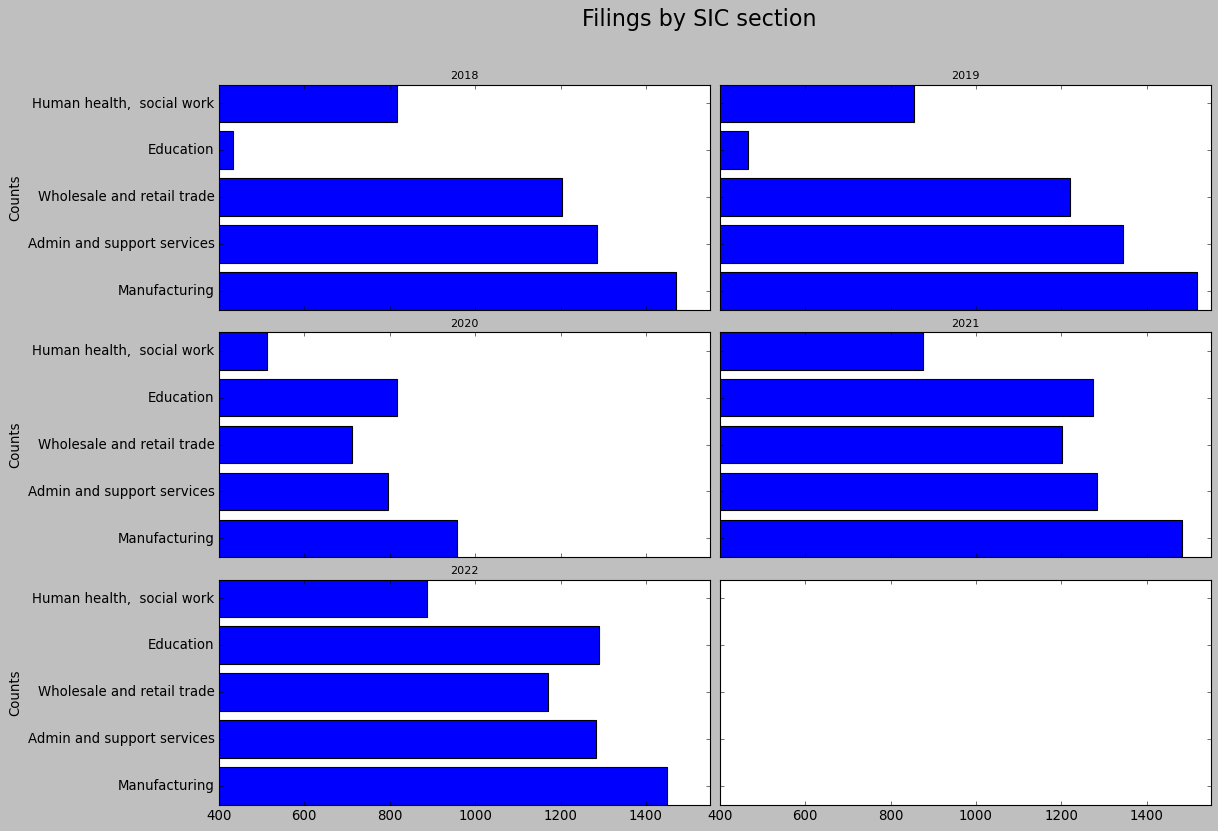

In [32]:
# Using matplotlib's histogram

nbins = 100

# The variable ax is a matplotlib AxesSubplot object.
# The variable fig is a matplotlib Figure object.
fig, ax = plt.subplots( nrows = 3
                    , ncols = 2
                    , figsize = (16, 12)
                    , sharey = True
                    , sharex = True
                      )

plt.subplots_adjust( left=0.125 
                    , bottom=0.15 
                    , right=0.9
                    , top=0.90 
                    , wspace=0.02
                    , hspace=0.1
                   )

# fig.tight_layout( pad=4.0 )
fig.suptitle( 'Filings by SIC section', fontsize = 20 )

ax[0, 0].set_ylabel( 'Counts' )
ax[1, 0].set_ylabel( 'Counts' )
ax[2, 0].set_ylabel( 'Counts' )

# xtick_list = [-500, -450, -400, -350, -300, -250, -200, -150, -100, -50, 0, 50, 100]
xtick_list = [ 400, 600, 800, 1000, 1200, 1400, 1600 ]

for iyear in range( 2018, 2023 ):
    i = iyear - 2018
    x = int( i / 2)
    y = i % 2
    r = ax[ x, y ]

    r.barh( y=dfxtab['sectiondescription'], width=dfxtab[iyear] )
    r.set_title( iyear, fontsize = 10 )

    # r.xaxis.set_major_locator( mticker.FixedLocator( xtick_list ))
    # r.set_xticklabels( labels=xtick_list, rotation=-90) 
    # r.set_xlabel( xlabel = 'Diff Mean Hourly Pct' )

plt.xlim(400, 1550)

del i, x, y, r

plt.show() ;